# **Penerapan big data analytics dalam analisis dan prediksi keterlambatan penerbangan menggunakan algoritma logistic regression dan random forest**

#**Nama Anggota Kelompok :**
1. Rifky Danu Asmoro 23.11.5489
2. Vianda Retnaningtiyas Purbandari Karetji 23.11.5445
3. Debi Saputra 23.11.5480
4. Stefanus Arya Bayu Samudra Bataona 23.11.5477

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *


In [ ]:
spark = SparkSession.builder \
    .appName("FlightDelayBigDataAnalytics") \
    .getOrCreate()

spark


# **LOAD DATASET CSV**

In [ ]:
from google.colab import files
print("Upload file kaggle.json :")
files.upload()

Upload file kaggle.json :


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rifkydanu","key":"4017eeac50c165a122c79dc8dd8181f2"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bordanova/2023-us-civil-flights-delay-meteo-and-aircraft

Dataset URL: https://www.kaggle.com/datasets/bordanova/2023-us-civil-flights-delay-meteo-and-aircraft
License(s): CC0-1.0
  0% 0.00/127M [00:00<?, ?B/s]
100% 127M/127M [00:00<00:00, 1.38GB/s]


In [ ]:
!unzip 2023-us-civil-flights-delay-meteo-and-aircraft.zip

Archive:  2023-us-civil-flights-delay-meteo-and-aircraft.zip
  inflating: Cancelled_Diverted_2023.csv  
  inflating: US_flights_2023.csv     
  inflating: airports_geolocation.csv  
  inflating: maj us flight - january 2024.csv  
  inflating: weather_meteo_by_airport.csv  


# **VALIDASI DATA**

In [ ]:
airports_df = spark.read.csv("airports_geolocation.csv", header=True, inferSchema=True)
canceled_df = spark.read.csv("Cancelled_Diverted_2023.csv", header=True, inferSchema=True)
weather_df = spark.read.csv("weather_meteo_by_airport.csv", header=True, inferSchema=True)
flights_df = spark.read.csv("US_flights_2023.csv", header=True, inferSchema=True)

airports_df.printSchema()
canceled_df.printSchema()
weather_df.printSchema()
flights_df.printSchema()

root
 |-- IATA_CODE: string (nullable = true)
 |-- AIRPORT: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)

root
 |-- FlightDate: date (nullable = true)
 |-- Day_Of_Week: integer (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- Diverted: double (nullable = true)
 |-- Dep_Airport: string (nullable = true)
 |-- Dep_CityName: string (nullable = true)
 |-- DepTime_label: string (nullable = true)
 |-- Dep_Delay: double (nullable = true)
 |-- Dep_Delay_Tag: integer (nullable = true)
 |-- Dep_Delay_Type: string (nullable = true)
 |-- Arr_Airport: string (nullable = true)
 |-- Arr_CityName: string (nullable = true)
 |-- Arr_Delay: double (nullable = true)
 |-- Arr_Delay_Type: string (nullable = true)
 |-- Flight_Duration: double (

Kode diatas digunakan untuk menampilkan struktur atau skema dari masing-masing DataFrame, sehingga kita bisa mengetahui nama kolom, tipe data dari masing masing kolom.

In [ ]:

airports_df.show(5)
canceled_df.show(5)
weather_df.show(5)
flights_df.show(5)


+---------+--------------------+-----------+-----+-------+--------+----------+
|IATA_CODE|             AIRPORT|       CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+---------+--------------------+-----------+-----+-------+--------+----------+
|      ABE|Lehigh Valley Int...|  Allentown|   PA|    USA|40.65236|  -75.4404|
|      ABI|Abilene Regional ...|    Abilene|   TX|    USA|32.41132|  -99.6819|
|      ABQ|Albuquerque Inter...|Albuquerque|   NM|    USA|35.04022|-106.60919|
|      ABR|Aberdeen Regional...|   Aberdeen|   SD|    USA|45.44906| -98.42183|
|      ABY|Southwest Georgia...|     Albany|   GA|    USA|31.53552| -84.19447|
+---------+--------------------+-----------+-----+-------+--------+----------+
only showing top 5 rows

+----------+-----------+------------+-----------+---------+--------+-----------+---------------+-------------+---------+-------------+------------------+-----------+-------------------+---------+----------------+---------------+-------------+-------------+--------

#**MAP REDUCE**

In [ ]:
delay_rdd = flights_df.select(
    "Dep_Airport",
    "Dep_Delay"
).rdd


In [ ]:
mapped_rdd = delay_rdd.map(
    lambda x: (x.Dep_Airport, 1 if x.Dep_Delay > 0 else 0)
)


In [ ]:
delay_by_airport = mapped_rdd.reduceByKey(lambda a, b: a + b)

delay_by_airport.take(10)


[('EVV', 398),
 ('XNA', 3099),
 ('CHS', 7943),
 ('MOT', 586),
 ('ABY', 136),
 ('CMH', 11528),
 ('HSV', 2182),
 ('BHM', 5053),
 ('GPT', 600),
 ('MSY', 20207)]

#**EDA**

In [ ]:
flights_df.select(
    "Dep_Delay",
    "Arr_Delay",
    "Flight_Duration"
).describe().show()


+-------+------------------+------------------+------------------+
|summary|         Dep_Delay|         Arr_Delay|   Flight_Duration|
+-------+------------------+------------------+------------------+
|  count|           6743404|           6743404|           6743404|
|   mean|12.200986623373003|  6.62715150983094|140.29777854033364|
| stddev| 55.07936114175984|57.078921452308755| 72.87215749288366|
|    min|               -99|              -119|                 0|
|    max|              4413|              4405|               795|
+-------+------------------+------------------+------------------+



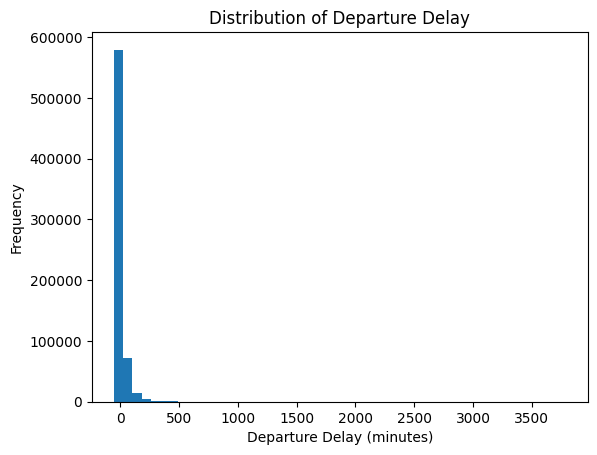

In [ ]:
import matplotlib.pyplot as plt

delay_pd = flights_df.select("Dep_Delay") \
    .sample(fraction=0.1, seed=42) \
    .toPandas()

plt.hist(delay_pd["Dep_Delay"], bins=50)
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Frequency")
plt.title("Distribution of Departure Delay")
plt.show()


#**DATA PREPROCESSING**

In [ ]:
flights_df = flights_df.withColumn(
    "FlightDate", to_date(col("FlightDate"))
)

canceled_df = canceled_df.withColumn(
    "FlightDate", to_date(col("FlightDate"))
)

weather_df = weather_df.withColumn(
    "time", to_date(col("time"))
)


In [ ]:
from pyspark.sql.functions import col, sum

flights_df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in flights_df.columns
]).show()

canceled_df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in canceled_df.columns
]).show()

weather_df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in weather_df.columns
]).show()

airports_df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in airports_df.columns
]).show()


+----------+-----------+-------+-----------+-----------+------------+-------------+---------+-------------+--------------+-----------+------------+---------+--------------+---------------+-------------+-------------+-------------+---------+--------------+------------------+------------+-----+-----------+
|FlightDate|Day_Of_Week|Airline|Tail_Number|Dep_Airport|Dep_CityName|DepTime_label|Dep_Delay|Dep_Delay_Tag|Dep_Delay_Type|Arr_Airport|Arr_CityName|Arr_Delay|Arr_Delay_Type|Flight_Duration|Distance_type|Delay_Carrier|Delay_Weather|Delay_NAS|Delay_Security|Delay_LastAircraft|Manufacturer|Model|Aicraft_age|
+----------+-----------+-------+-----------+-----------+------------+-------------+---------+-------------+--------------+-----------+------------+---------+--------------+---------------+-------------+-------------+-------------+---------+--------------+------------------+------------+-----+-----------+
|         0|          0|      0|          0|          0|           0|            0

In [ ]:
from pyspark.sql.functions import col

clean_df = flights_df \
    .withColumn("Dep_Delay", col("Dep_Delay").cast("integer")) \
    .withColumn("Arr_Delay", col("Arr_Delay").cast("integer")) \
    .withColumn("Flight_Duration", col("Flight_Duration").cast("integer")) \
    .dropna(subset=["Dep_Delay", "Arr_Delay", "Flight_Duration"])


In [ ]:
clean_df.printSchema()


root
 |-- FlightDate: date (nullable = true)
 |-- Day_Of_Week: integer (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Dep_Airport: string (nullable = true)
 |-- Dep_CityName: string (nullable = true)
 |-- DepTime_label: string (nullable = true)
 |-- Dep_Delay: integer (nullable = true)
 |-- Dep_Delay_Tag: integer (nullable = true)
 |-- Dep_Delay_Type: string (nullable = true)
 |-- Arr_Airport: string (nullable = true)
 |-- Arr_CityName: string (nullable = true)
 |-- Arr_Delay: integer (nullable = true)
 |-- Arr_Delay_Type: string (nullable = true)
 |-- Flight_Duration: integer (nullable = true)
 |-- Distance_type: string (nullable = true)
 |-- Delay_Carrier: integer (nullable = true)
 |-- Delay_Weather: integer (nullable = true)
 |-- Delay_NAS: integer (nullable = true)
 |-- Delay_Security: integer (nullable = true)
 |-- Delay_LastAircraft: integer (nullable = true)
 |-- Manufacturer: string (nullable = true)
 |-- Model: string 

#**MANIPULASI DATA**

In [ ]:
clean_df.createOrReplaceTempView("flights")

spark.sql("""
    SELECT
        Dep_Airport,
        COUNT(*) AS total_flights,
        AVG(Dep_Delay) AS avg_dep_delay,
        AVG(Arr_Delay) AS avg_arr_delay
    FROM flights
    GROUP BY Dep_Airport
    ORDER BY avg_dep_delay DESC
""").show(10)


+-----------+-------------+------------------+------------------+
|Dep_Airport|total_flights|     avg_dep_delay|     avg_arr_delay|
+-----------+-------------+------------------+------------------+
|        SMX|          106|  61.5377358490566| 67.13207547169812|
|        COD|           33| 46.96969696969697|41.515151515151516|
|        PPG|          124| 37.33870967741935|36.556451612903224|
|        HTS|          397| 34.00755667506297| 32.24685138539043|
|        USA|          750|30.026666666666667|28.873333333333335|
|        BIH|          241| 29.34439834024896|16.759336099585063|
|        DEC|          964|28.850622406639005| 23.37551867219917|
|        CIU|          710|28.718309859154928|17.180281690140845|
|        MVY|         1088|27.857536764705884|22.376838235294116|
|        IAG|          331|26.416918429003022| 23.06646525679758|
+-----------+-------------+------------------+------------------+
only showing top 10 rows



# **JOIN**

In [ ]:
flights_airport_df = flights_df.join(
    airports_df,
    flights_df.Dep_Airport == airports_df.IATA_CODE,
    "left"
).select(
    flights_df["*"],
    airports_df.AIRPORT.alias("Dep_Airport_Name"),
    airports_df.CITY.alias("Dep_City"),
    airports_df.STATE.alias("Dep_State"),
    airports_df.LATITUDE.alias("Dep_Lat"),
    airports_df.LONGITUDE.alias("Dep_Lon")
)


In [ ]:
flights_weather_df = flights_airport_df.join(
    weather_df,
    (flights_airport_df.Dep_Airport == weather_df.airport_id) &
    (flights_airport_df.FlightDate == weather_df.time),
    "left"
)


In [ ]:
full_df = flights_weather_df.join(
    canceled_df.select(
        "FlightDate",
        "Tail_Number",
        "Cancelled",
        "Diverted"
    ),
    on=["FlightDate", "Tail_Number"],
    how="left"
)


In [ ]:
final_df = full_df.select(
    "FlightDate",
    "Airline",
    "Dep_Airport",
    "Arr_Airport",
    "Dep_Delay",
    "Arr_Delay",
    "Cancelled",
    "Diverted",
    "tavg",
    "prcp",
    "snow",
    "wspd",
    "pres",
    "Manufacturer",
    "Model",
    "Aicraft_age",
    "Flight_Duration",
    "Day_Of_Week"
)

In [ ]:
final_df.show(5)
final_df.printSchema()


+----------+------------+-----------+-----------+---------+---------+---------+--------+----+----+----+----+------+--------------------+-----+-----------+---------------+-----------+
|FlightDate|     Airline|Dep_Airport|Arr_Airport|Dep_Delay|Arr_Delay|Cancelled|Diverted|tavg|prcp|snow|wspd|  pres|        Manufacturer|Model|Aicraft_age|Flight_Duration|Day_Of_Week|
+----------+------------+-----------+-----------+---------+---------+---------+--------+----+----+----+----+------+--------------------+-----+-----------+---------------+-----------+
|2023-01-02|Endeavor Air|        BDL|        LGA|       -3|      -12|     NULL|    NULL| 2.9| 0.0| 0.0| 3.2|1019.1|CANADAIR REGIONAL...|  CRJ|         16|             56|          1|
|2023-01-03|Endeavor Air|        BDL|        LGA|       -5|       -8|     NULL|    NULL| 1.8|10.7| 0.0| 3.6|1015.2|CANADAIR REGIONAL...|  CRJ|         16|             62|          2|
|2023-01-04|Endeavor Air|        BDL|        LGA|       -5|      -21|     NULL|    NU

In [ ]:
from pyspark.sql.functions import avg

final_df.select(
    avg(col("Cancelled")).alias("cancel_rate")
).show()


+------------------+
|       cancel_rate|
+------------------+
|0.8281777041982854|
+------------------+



Kode tersebut digunakan untuk menghitung rata-rata dari kolom Cancelled pada DataFrame final_df, sehingga menghasilkan nilai yang menunjukkan tingkat atau persentase pembatalan penerbangan, lalu menampilkannya dengan nama alias cancel_rate.

In [ ]:
final_df.groupBy("snow") \
    .avg("Dep_Delay") \
    .orderBy("snow") \
    .show()

+-----+-------------------+
| snow|     avg(Dep_Delay)|
+-----+-------------------+
|  0.0| 12.420892693662488|
| 10.0| 34.214285714285715|
| 20.0|-1.8666666666666667|
| 25.0| 12.574294205052006|
| 30.0| 15.852852128714197|
| 40.0|              23.75|
| 50.0| 15.596588155471553|
| 51.0|  6.981395348837209|
| 60.0|              -4.75|
| 70.0|              -8.75|
| 76.0|               2.35|
| 80.0|   17.8242148554337|
| 90.0|               67.0|
|100.0|   17.2058299162061|
|102.0|               14.0|
|110.0|              -6.75|
|127.0|               9.48|
|130.0| 15.055911045840764|
|140.0|             162.75|
|150.0| 24.630790910692266|
+-----+-------------------+
only showing top 20 rows



In [ ]:
ml_df = final_df.dropna()

In [ ]:
final_df.describe(
    "Dep_Delay",
    "Arr_Delay",
    "Flight_Duration",
    "tavg",
    "prcp",
    "snow",
    "wspd",
    "Aicraft_age"
).show()


+-------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|        Dep_Delay|        Arr_Delay|   Flight_Duration|              tavg|              prcp|              snow|              wspd|      Aicraft_age|
+-------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|  count|          6825926|          6825926|           6825926|           6825926|           6825926|           6825926|           6825926|          6825926|
|   mean|12.49771488879311|6.972089647617041|140.06788763898115|16.809516225345718|2.4866379301526855|3.2787283366388675|12.486864968947879|13.48756505710727|
| stddev|55.83225079872703|57.87230516990821| 72.71177551344113| 9.172621340295954| 8.442573245217417|31.354273108272242| 5.652210986559355| 7.88034804857956|
|    min|              -99|             -119| 

Kode diatas digunakan untuk menampilkan statistik deskriptif dari tabel hasil join atau final_df

In [ ]:
from pyspark.sql.functions import when

final_df.select(
    when(col("Dep_Delay") > 0, "Delayed")
    .otherwise("On Time")
    .alias("Dep_Status")
).groupBy("Dep_Status").count().show()


+----------+-------+
|Dep_Status|  count|
+----------+-------+
|   On Time|4228531|
|   Delayed|2597395|
+----------+-------+



Kode diatas digunakan untuk membuat kolom baru bernama Dep_Status yang mengklasifikasikan penerbangan menjadi Delayed jika nilai keterlambatan keberangkatan lebih besar dari nol, atau On Time jika tidak, kemudian menghitung jumlah penerbangan dalam masing-masing kategori.


In [ ]:
final_df.groupBy("Cancelled") \
    .avg("prcp", "snow", "wspd") \
    .show()


+---------+------------------+------------------+------------------+
|Cancelled|         avg(prcp)|         avg(snow)|         avg(wspd)|
+---------+------------------+------------------+------------------+
|      0.0| 6.174456164180055| 4.316708758674845| 12.80680617160804|
|     NULL|2.3518937007927083|3.1560545782427294|12.457172594271665|
|      1.0| 5.608607647328094| 6.602253513684878| 13.27704810842246|
+---------+------------------+------------------+------------------+



Kode ini membantu mengidentifikasi bahwa salju, curah hujan dan angin mungkin berperan lebih besar dalam pembatalan penerbangan dibandingkan curah hujan. Ini bisa berguna untuk analisis risiko atau prediksi pembatalan berdasarkan kondisi cuaca. Nilai Cancelled = 0 artinya adalah penerbangan yang tidak tertunda, nilai Cancelled : Null artinya tidak ada penjelasan apakah penerbangan tertunda atau tidaak tertunda dan nilai Cancelled : 1 artinya penerbangan yang tertunda

In [ ]:
final_df.groupBy("Day_Of_Week") \
    .avg("Dep_Delay") \
    .orderBy("Day_Of_Week") \
    .show()


+-----------+------------------+
|Day_Of_Week|    avg(Dep_Delay)|
+-----------+------------------+
|          1|12.671263197108525|
|          2| 9.692581135437962|
|          3|11.321478750559576|
|          4|12.345708926911858|
|          5| 13.85391770061239|
|          6|12.630633247005282|
|          7|14.786939009376932|
+-----------+------------------+



In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

corr_features = [
    "Dep_Delay",
    "tavg",
    "prcp",
    "snow",
    "wspd",
    "Aicraft_age"
]

corr_df = final_df.select(corr_features).dropna()

assembler = VectorAssembler(
    inputCols=corr_features,
    outputCol="features"
)

corr_vector = assembler.transform(corr_df).select("features")
Correlation.corr(corr_vector, "features").show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pearson(features)                                                                                                                                                                                                                                                                                             |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1.0                   0.04294503712430344   ... (6 total)\n0.04294503712430344   1.0

Kode diatas digunakan untuk mengubah data numerik menjadi format vektor sehingga bisa dihitung matriks korelasi antar variabel menggunakan fungsi Correlation dengan metode pearson agar bisa mengetahui seberapa kuat hubungan antara keterlambatan penerbangan dengan faktor cuaca maupun usia pesawat.


#**OPERASI PARTISI RDD (map, flatMap, aggregateByKey)**

In [ ]:
airport_delay_rdd = clean_df.select(
    "Dep_Airport",
    "Dep_Delay"
).rdd.flatMap(lambda x: [(x.Dep_Airport, x.Dep_Delay)])


In [ ]:
delay_stats = airport_delay_rdd.aggregateByKey(
    (0, 0),
    lambda acc, v: (acc[0] + v, acc[1] + 1),
    lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])
)

avg_delay_rdd = delay_stats.mapValues(lambda x: x[0] / x[1])

avg_delay_rdd.take(10)


[('EVV', 8.65747613997879),
 ('XNA', 9.145366023300296),
 ('CHS', 12.666997477566886),
 ('MOT', 11.191842900302115),
 ('ABY', 7.291358024691358),
 ('CMH', 7.8718509060551),
 ('HSV', 9.932742908484148),
 ('BHM', 10.191200814975168),
 ('GPT', 5.204940848990954),
 ('MSY', 12.751740897302374)]

# **MODEL**

In [ ]:
ml_df = final_df.withColumn(
    "label",
    when(col("Dep_Delay") > 15, 1).otherwise(0)
)


Kode tersebut digunakan untuk menambahkan kolom baru bernama label yang berisi nilai 1 jika keterlambatan keberangkatan lebih dari 15 menit dan nilai 0 jika keterlambatan kurang dari sama dengan 15 menit.

In [ ]:
features = [
    "tavg",
    "prcp",
    "snow",
    "wspd",
    "Aicraft_age",
    "Flight_Duration"
]

ml_df = ml_df.select(features + ["label"]).dropna()


Kode diatas digunakan untuk memilih fitur fitur yang relevan untuk membangun model

In [ ]:
assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)

ml_ready_df = assembler.transform(ml_df) \
    .select("features", "label")


Kode tersebut digunakan untuk menggabungkan semua kolom fitur yang telah dipilih menjadi satu vektor pada kolom baru bernama features, kemudian menghasilkan DataFrame baru yang hanya berisi kolom features dan label, sehingga data siap digunakan sebagai input dalam proses pelatihan model.

In [ ]:
train_df, test_df = ml_ready_df.randomSplit([0.8, 0.2], seed=42)


Kode diatas digunakan untuk membagi dataset ml_ready_df menjadi dua bagian, yaitu train_df yang berisi sekitar 80% data untuk melatih model dan test_df yang berisi sekitar 20% data untuk menguji atau melakukan test performa model, dengan pembagian yang konsisten karena menggunakan nilai acak tetap (seed=42).


**LOGISTIC REGRESSION**

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    maxIter=20,
    regParam=0.01
)

model = lr.fit(train_df)


Kode diatas digunakan untuk membuat sebuah model klasifikasi dengan algoritma Logistic Regression, di mana model dilatih menggunakan train_df dengan maksimum iterasi 20 kali dan nilai regularisasi sebesar 0.01, sehingga menghasilkan model yang siap digunakan untuk memprediksi apakah penerbangan mengalami keterlambatan atau tidak.


In [ ]:
predictions = model.transform(test_df)
predictions.select("label", "prediction", "probability").show(5)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.91870010720084...|
|    0|       0.0|[0.90290456202828...|
|    0|       0.0|[0.89048998623266...|
|    0|       0.0|[0.91133499492183...|
|    1|       0.0|[0.89659332822278...|
+-----+----------+--------------------+
only showing top 5 rows



In [ ]:
predictions.groupBy("label", "prediction").count().show()


+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    1|       0.0| 272461|
|    0|       0.0|1091183|
|    1|       1.0|    779|
|    0|       1.0|    943|
+-----+----------+-------+



kode diatas digunakan untuk mengelompokkan data berdasarkan label asli dan hasil prediksi, lalu menghitung jumlah data pada setiap kombinasi label prediksi. Hasil tabel diatas menunjukkan bahwa jumlah True Positive : 779, True Negative : 1091183, False Positive : 943, dan False Negative : 272461

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)


Accuracy: 0.7997577206404729


In [ ]:
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)

print("Precision:", precision_evaluator.evaluate(predictions))
print("Recall:", recall_evaluator.evaluate(predictions))


Precision: 0.730590808041372
Recall: 0.7997577206404729


**RANDOM FOREST**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    numTrees=50,
    maxDepth=5,
    seed=42
)

rf_model = rf.fit(train_df)

In [ ]:
predictions_rf = rf_model.transform(test_df)
predictions_rf.select("label", "prediction", "probability").show(5)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.80502336005862...|
|    0|       0.0|[0.80502336005862...|
|    0|       0.0|[0.80502336005862...|
|    0|       0.0|[0.80502336005862...|
|    1|       0.0|[0.80502336005862...|
+-----+----------+--------------------+
only showing top 5 rows



In [ ]:
predictions_rf.groupBy("label", "prediction").count().show()

+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    1|       0.0| 273240|
|    0|       0.0|1092126|
+-----+----------+-------+



In [ ]:
accuracy_evaluator_rf = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy_rf = accuracy_evaluator_rf.evaluate(predictions_rf)
print("Accuracy:", accuracy_rf)

precision_evaluator_rf = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

recall_evaluator_rf = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)

print("Precision:", precision_evaluator.evaluate(predictions))
print("Recall:", recall_evaluator.evaluate(predictions))



Accuracy: 0.7998778349541442
Precision: 0.730590808041372
Recall: 0.7997577206404729


**PERBANDINGAN**

In [ ]:
print("LOGISTIC REGRESSION : \n")
print("Accuracy:", accuracy)
print("Precision:", precision_evaluator.evaluate(predictions))
print("Recall:", recall_evaluator.evaluate(predictions))
print("\n\nRANDOM FOREST : \n")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_evaluator_rf.evaluate(predictions_rf))
print("Recall:", recall_evaluator_rf.evaluate(predictions_rf))

LOGISTIC REGRESSION : 

Accuracy: 0.7997577206404729
Precision: 0.730590808041372
Recall: 0.7997577206404729


RANDOM FOREST : 

Accuracy: 0.7998778349541442
Precision: 0.6398045508509291
Recall: 0.7998778349541442


Logistic Regression merupakan model terbaik karena memiliki nilai precision lebih tinggi dibandingkan Random Forest, sementara accuracy dan recall keduanya hampir sama.

# **HYPERPARAMETER TUNING**

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression()

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.maxIter, [20, 50]) \
    .build()


In [ ]:
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cv_model = cv.fit(train_df)
best_model = cv_model.bestModel


# **EVALUASI MATRIKS MODEL**

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_eval = MulticlassClassificationEvaluator(metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(metricName="f1")

accuracy = accuracy_eval.evaluate(best_model.transform(test_df))
f1 = f1_eval.evaluate(best_model.transform(test_df))
auc = evaluator.evaluate(best_model.transform(test_df))

print("Accuracy :", accuracy)
print("F1-Score :", f1)
print("AUC      :", auc)


Accuracy : 0.7998822293802541
F1-Score : 0.711293197089294
AUC      : 0.5765235117645753


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

auc_evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    metricName="areaUnderROC"
)

auc = auc_evaluator.evaluate(predictions)
print("AUC:", auc)


AUC: 0.5763773445554414


In [ ]:
from pyspark.sql import Row

input_data = [
    Row(
        tavg=7.5,
        prcp=12.0,
        snow=0.0,
        wspd=15.2,
        Aicraft_age=14,
        Flight_Duration=95
    )
]

input_df = spark.createDataFrame(input_data)
input_df.show()

+----+----+----+----+-----------+---------------+
|tavg|prcp|snow|wspd|Aicraft_age|Flight_Duration|
+----+----+----+----+-----------+---------------+
| 7.5|12.0| 0.0|15.2|         14|             95|
+----+----+----+----+-----------+---------------+



Kode diatas digunakan untuk input data random untuk dimasukkan kedalam model untuk prediksi

In [ ]:
input_features = assembler.transform(input_df)
input_features.show(truncate=False)


+----+----+----+----+-----------+---------------+-----------------------------+
|tavg|prcp|snow|wspd|Aicraft_age|Flight_Duration|features                     |
+----+----+----+----+-----------+---------------+-----------------------------+
|7.5 |12.0|0.0 |15.2|14         |95             |[7.5,12.0,0.0,15.2,14.0,95.0]|
+----+----+----+----+-----------+---------------+-----------------------------+



In [ ]:
prediction_result = model.transform(input_features)
prediction_result.select(
    "prediction",
    "probability"
).show(truncate=False)

+----------+----------------------------------------+
|prediction|probability                             |
+----------+----------------------------------------+
|0.0       |[0.8041863029808051,0.19581369701919493]|
+----------+----------------------------------------+



In [ ]:
def predict_delay(
    tavg, prcp, snow, wspd, aircraft_age, flight_duration
):
    df = spark.createDataFrame([
        (tavg, prcp, snow, wspd, aircraft_age, flight_duration)
    ], [
        "tavg", "prcp", "snow", "wspd", "Aicraft_age", "Flight_Duration"
    ])

    vec = assembler.transform(df)
    result = model.transform(vec)

    return result.select("prediction", "probability")


In [ ]:
future_df = final_df.filter(col("FlightDate") == "2023-01-15")

future_features = assembler.transform(future_df)
future_predictions = model.transform(future_features)

future_predictions.select(
    "Dep_Airport",
    "Arr_Airport",
    "Dep_Delay",
    "prediction",
    "probability"
).show(10)


+-----------+-----------+---------+----------+--------------------+
|Dep_Airport|Arr_Airport|Dep_Delay|prediction|         probability|
+-----------+-----------+---------+----------+--------------------+
|        LGA|        BGM|        5|       0.0|[0.85219393825186...|
|        ATL|        FAY|       -3|       0.0|[0.86384217649088...|
|        FAY|        ATL|       -5|       0.0|[0.84872690455117...|
|        JFK|        ITH|      110|       0.0|[0.81916638842881...|
|        BWI|        JFK|       -2|       0.0|[0.83372613144120...|
|        JFK|        BWI|       -1|       0.0|[0.82369639886194...|
|        MSP|        CID|        8|       0.0|[0.80288330867017...|
|        LGA|        SDF|       -8|       0.0|[0.83893227913885...|
|        ATL|        CRW|       -7|       0.0|[0.86150165908494...|
|        CRW|        ATL|       -5|       0.0|[0.87799155094596...|
+-----------+-----------+---------+----------+--------------------+
only showing top 10 rows



<Axes: title={'center': 'Distribusi Keterlambatan Penerbangan'}, xlabel='label'>

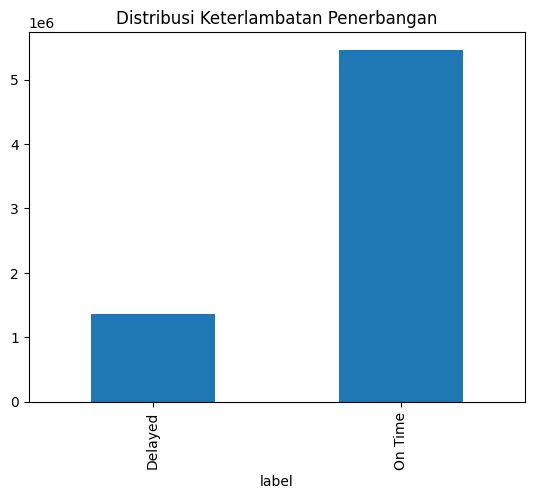

In [ ]:
delay_dist = ml_df.groupBy("label").count().toPandas()

delay_dist["label"] = delay_dist["label"].map({
    0: "On Time",
    1: "Delayed"
})

delay_dist.plot(
    x="label",
    y="count",
    kind="bar",
    legend=False,
    title="Distribusi Keterlambatan Penerbangan"
)


<Axes: title={'center': 'prcp'}, xlabel='Status'>

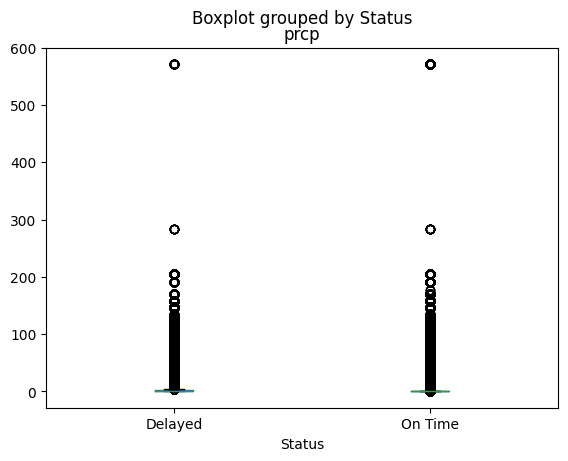

In [ ]:
weather_delay = final_df.select("prcp", "Dep_Delay").dropna().toPandas()

weather_delay["Status"] = weather_delay["Dep_Delay"].apply(
    lambda x: "Delayed" if x > 15 else "On Time"
)

weather_delay.boxplot(
    column="prcp",
    by="Status",
    grid=False
)


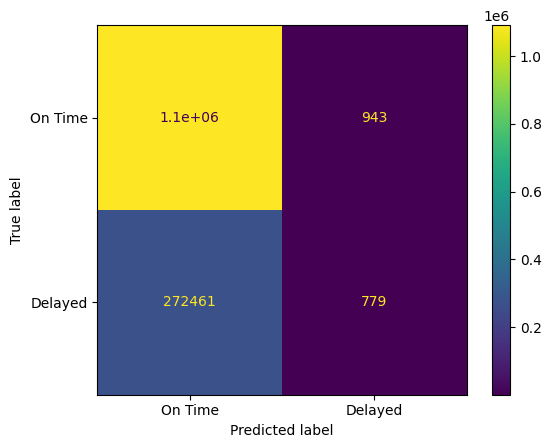

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_df = predictions.select("label", "prediction").toPandas()

cm = confusion_matrix(cm_df["label"], cm_df["prediction"])

ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["On Time", "Delayed"]
).plot()


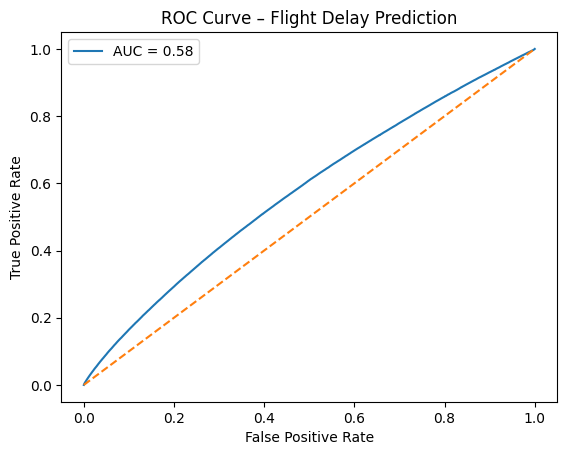

In [ ]:
from sklearn.metrics import roc_curve, auc

roc_df = predictions.select("label", "probability").toPandas()

roc_df["prob_delay"] = roc_df["probability"].apply(lambda x: x[1])

fpr, tpr, _ = roc_curve(roc_df["label"], roc_df["prob_delay"])
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Flight Delay Prediction")
plt.legend()
plt.show()


<Axes: title={'center': 'Pengaruh Fitur terhadap Delay'}, ylabel='Feature'>

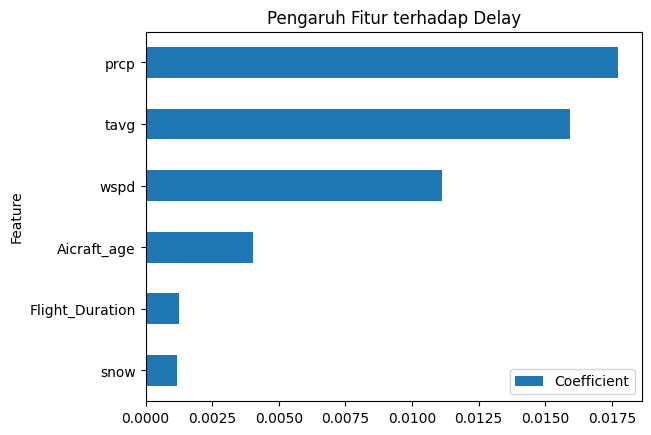

In [ ]:
import pandas as pd

coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coefficients.toArray()
})

coef_df.sort_values("Coefficient").plot(
    x="Feature",
    y="Coefficient",
    kind="barh",
    title="Pengaruh Fitur terhadap Delay"
)
